<a href="https://colab.research.google.com/github/AbhiJeet70/GraphPoisoningCodes/blob/main/UGBA_Planetoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing dataset: Cora
Statistics for Cora:
  Number of nodes: 2708
  Number of edges: 10556
  Number of features: 1433
  Number of classes: 7
  Class distribution: [351 217 418 818 426 298 180]
Early stopping at epoch 319
Accuracy before UGBA: 0.807
Early stopping at epoch 155
Early stopping at epoch 165
Early stopping at epoch 184
Early stopping at epoch 116
Processing dataset: Citeseer
Statistics for Citeseer:
  Number of nodes: 3327
  Number of edges: 9104
  Number of features: 3703
  Number of classes: 6
  Class distribution: [264 590 668 701 596 508]
Early stopping at epoch 242
Accuracy before UGBA: 0.695
Early stopping at epoch 131
Early stopping at epoch 103
Early stopping at epoch 101
Early stopping at epoch 116
Processing dataset: Pubmed
Statistics for Pubmed:
  Number of nodes: 19717
  Number of edges: 88648
  Number of features: 500
  Number of classes: 3
  Class distribution: [4103 7739 7875]
Accuracy before UGBA: 0.765
Early stopping at epoch 108
Early stopping at epoch

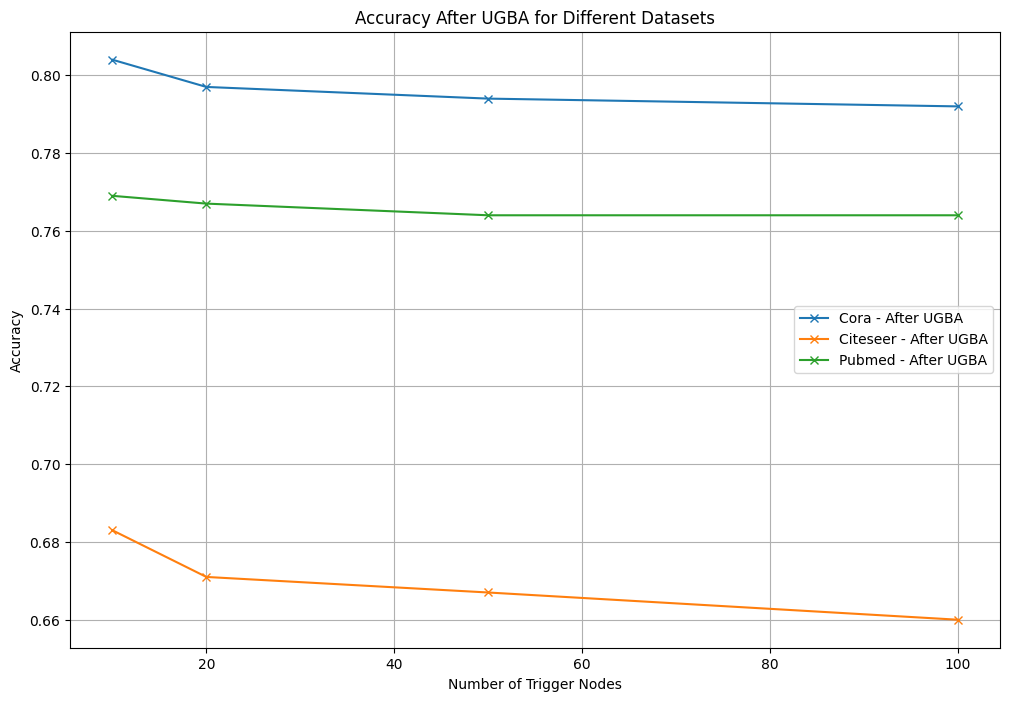

In [ ]:
# Install necessary packages
!pip install torch torch-geometric pandas matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

set_seed(20)

# Define the GCN model
class GCNNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# UGBA-related classes and methods
class HomoLoss(nn.Module):
    def __init__(self):
        super(HomoLoss, self).__init__()

    def forward(self, adj, h, target):
        h = torch.cat([h, torch.zeros(adj.size(1) - h.size(0), h.size(1), device=h.device)], dim=0)
        row, col = adj.nonzero(as_tuple=True)
        homophily = (h[row] * h[col]).sum(dim=1)
        target_homophily = target[row].float()
        return F.mse_loss(homophily, target_homophily)

class GraphTrojanNet(nn.Module):
    def __init__(self, num_features, num_trigger_nodes, num_classes):
        super(GraphTrojanNet, self).__init__()
        self.num_trigger_nodes = num_trigger_nodes
        self.trigger_node_features = nn.Parameter(torch.Tensor(num_trigger_nodes, num_features))
        self.trigger_node_labels = nn.Parameter(torch.Tensor(num_trigger_nodes, num_classes))

    def forward(self):
        return self.trigger_node_features, self.trigger_node_labels

class UGBA:
    def __init__(self, surrogate_model, trojan_net, homo_loss, num_trigger_nodes, target_class, lambda_=0.5, trojan_epochs=100, inner=1):
        self.surrogate_model = surrogate_model
        self.trojan_net = trojan_net
        self.homo_loss = homo_loss
        self.num_trigger_nodes = num_trigger_nodes
        self.target_class = target_class
        self.lambda_ = lambda_
        self.trojan_epochs = trojan_epochs
        self.inner = inner

    def fit(self, features, edge_index, labels, idx_attach):
        num_nodes = features.size(0)
        num_features = features.size(1)
        num_classes = labels.max().item() + 1

        self.trojan_net = GraphTrojanNet(num_features, self.num_trigger_nodes, num_classes)
        self.surrogate_model = GCNNet(in_channels=num_features, hidden_channels=512, out_channels=num_classes)
        self.homo_loss = HomoLoss()

        self.trojan_net.train()
        self.surrogate_model.train()

        trojan_optimizer = torch.optim.Adam(self.trojan_net.parameters(), lr=0.01)
        surrogate_optimizer = torch.optim.Adam(self.surrogate_model.parameters(), lr=0.01)

        for epoch in range(self.trojan_epochs):
            for _ in range(self.inner):
                surrogate_optimizer.zero_grad()
                output = self.surrogate_model(features, edge_index)
                loss = F.cross_entropy(output[idx_attach], labels[idx_attach])
                loss.backward()
                surrogate_optimizer.step()

            trojan_optimizer.zero_grad()
            trigger_node_features, trigger_node_labels = self.trojan_net()
            attach_features = torch.cat([features, trigger_node_features], dim=0).requires_grad_(True)
            attach_edge_index = torch.cat([edge_index, self.get_trojan_edge(num_nodes)], dim=1)
            output = self.surrogate_model(attach_features, attach_edge_index)
            expanded_h = torch.cat([features, torch.zeros(self.num_trigger_nodes, features.size(1))], dim=0).requires_grad_(True)
            loss = self.lambda_ * self.homo_loss(attach_edge_index, expanded_h, torch.ones_like(output[:, 0]))
            loss.backward()
            trojan_optimizer.step()

    def get_trojan_edge(self, num_nodes):
        trigger_nodes = torch.randint(0, num_nodes, (self.num_trigger_nodes,))
        return torch.stack([trigger_nodes, trigger_nodes.roll(1)], dim=0)

# Load data
def load_planetoid_data(dataset_name):
    dataset = Planetoid(root=f'/tmp/{dataset_name}', name=dataset_name, transform=NormalizeFeatures())
    return dataset[0]

# Split data indices
def split_indices(num_nodes, train_ratio=0.7, val_ratio=0.1):
    indices = np.random.permutation(num_nodes)
    train_end = int(train_ratio * num_nodes)
    val_end = int((train_ratio + val_ratio) * num_nodes)
    return torch.tensor(indices[:train_end]), torch.tensor(indices[train_end:val_end]), torch.tensor(indices[val_end:])

# Train the model
def train_model(model, pyg_data, lr, weight_decay):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pyg_data = pyg_data.to(device)
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_val_acc = 0
    patience = 100
    patience_counter = 0

    for epoch in range(1, 501):
        model.train()
        optimizer.zero_grad()
        out = model(pyg_data.x, pyg_data.edge_index)
        loss = F.cross_entropy(out[pyg_data.train_mask], pyg_data.y[pyg_data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
        val_correct = float(pred[pyg_data.val_mask].eq(pyg_data.y[pyg_data.val_mask]).sum().item())
        val_acc = val_correct / pyg_data.val_mask.sum().item()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    model.load_state_dict(best_model_state)
    model.eval()
    _, pred = model(pyg_data.x, pyg_data.edge_index).max(dim=1)
    correct = float(pred[pyg_data.test_mask].eq(pyg_data.y[pyg_data.test_mask]).sum().item())
    return correct / pyg_data.test_mask.sum().item()

# Define dataset statistics
def print_dataset_statistics(data, dataset_name):
    num_nodes = data.num_nodes
    num_edges = data.num_edges
    num_features = data.num_node_features
    num_classes = data.y.max().item() + 1
    class_distribution = torch.bincount(data.y).cpu().numpy()
    print(f"Statistics for {dataset_name}:")
    print(f"  Number of nodes: {num_nodes}")
    print(f"  Number of edges: {num_edges}")
    print(f"  Number of features: {num_features}")
    print(f"  Number of classes: {num_classes}")
    print(f"  Class distribution: {class_distribution}")

def run_ugba_experiments(data, model, best_hyperparams, num_trigger_nodes_list):
    results = []

    for num_trigger_nodes in num_trigger_nodes_list:
        surrogate_model = GCNNet(data.num_node_features, 512, data.y.max().item() + 1)
        trojan_net = GraphTrojanNet(data.num_node_features, num_trigger_nodes, data.y.max().item() + 1)
        homo_loss = HomoLoss()
        target_class = data.y.max().item()  # Assuming the last class is the target class

        ugba = UGBA(surrogate_model, trojan_net, homo_loss, num_trigger_nodes, target_class, best_hyperparams['Learning_Rate'], 100)
        ugba.fit(data.x, data.edge_index, data.y, data.train_mask)

        perturbed_edge_index = ugba.get_trojan_edge(data.num_nodes + num_trigger_nodes)

        # Ensure edge_index has valid indices
        perturbed_edge_index, _ = torch.unique(perturbed_edge_index, sorted=True, return_inverse=True, dim=1)

        # Retrain the model with perturbed edges
        acc_after = train_model(model, data, best_hyperparams['Learning_Rate'], best_hyperparams['Weight_Decay'])
        results.append({
            'Num_Trigger_Nodes': num_trigger_nodes,
            'Accuracy_After': acc_after
        })

    return results

# Main execution
if __name__ == "__main__":
    dataset_names = ['Cora', 'Citeseer', 'Pubmed']
    num_trigger_nodes_list = [10, 20, 50, 100]
    all_results = []

    for dataset_name in dataset_names:
        print(f"Processing dataset: {dataset_name}")
        data = load_planetoid_data(dataset_name)
        print_dataset_statistics(data, dataset_name)

        model = GCNNet(data.num_node_features, hidden_channels=64, out_channels=int(data.y.max().item()) + 1)
        best_hyperparams = {
            'Learning_Rate': 0.001,
            'Weight_Decay': 1e-4,
            'Hidden_Channels': 64,
        }

        accuracy_before = train_model(model, data, best_hyperparams['Learning_Rate'], best_hyperparams['Weight_Decay'])
        print(f"Accuracy before UGBA: {accuracy_before}")

        exp_results = run_ugba_experiments(data, model, best_hyperparams, num_trigger_nodes_list)

        for result in exp_results:
            all_results.append({
                'Dataset': dataset_name,
                **result
            })

    results_df = pd.DataFrame(all_results)

    # Plot results
    plt.figure(figsize=(12, 8))
    for dataset_name in dataset_names:
        subset = results_df[results_df['Dataset'] == dataset_name]
        plt.plot(subset['Num_Trigger_Nodes'], subset['Accuracy_After'], label=f'{dataset_name} - After UGBA', marker='x')

    plt.xlabel('Number of Trigger Nodes')
    plt.ylabel('Accuracy')
    plt.title('Accuracy After UGBA for Different Datasets')
    plt.legend()
    plt.grid(True)
    plt.show()
